In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
# import collections
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sp_sparse
import tables
import statsmodels.api as sm
sns.set_style("darkgrid")

In [3]:
from scipy.io import mmread
import csv

## Load raw data 

In [4]:
X=mmread('./matrix.tcc.mtx')
X=X.tocsr()

#### load dictionaries

In [5]:
with open('./TX_to_ENST.csv', 'r') as csv_file:
    reader = csv.reader(csv_file,delimiter='\t')
    TX_to_ENST = dict(reader)
TX_to_ENST = {int(k): v for k,v in TX_to_ENST.items()}

with open('./TX_to_ENSG.csv', 'r') as csv_file:
    reader = csv.reader(csv_file,delimiter='\t')
    TX_to_ENSG = dict(reader)
TX_to_ENSG = {int(k): v for k,v in TX_to_ENSG.items()}

with open('./ENSG_to_name.csv', 'r') as csv_file:
    reader = csv.reader(csv_file,delimiter='\t')
    ENSG_to_name = dict(reader)

with open('./matrix.ec', 'r') as csv_file:
    reader = csv.reader(csv_file,delimiter='\t')
    EC_dict=dict(reader)
EC_dict = {int(k):[int(i) for i in v.split(',')] for k,v in EC_dict.items()}

### example:

In [6]:
## example for for equivalence class id 123456

print(EC_dict[123456]) #the transcript ids contained in this eq class
print([TX_to_ENST[i] for i in EC_dict[123456]]) # the ensembl ids of the transcripts 
print([TX_to_ENSG[i] for i in EC_dict[123456]]) # the ensembl gene ids of the transcripts
print([ENSG_to_name[TX_to_ENSG[i]] for i in EC_dict[123456]]) # the corresponding gene names

[95145, 95148, 95152, 95154, 95155, 95157]
['ENST00000468410', 'ENST00000222574', 'ENST00000485846', 'ENST00000463202', 'ENST00000498408', 'ENST00000483809']
['ENSG00000105856', 'ENSG00000105856', 'ENSG00000105856', 'ENSG00000105856', 'ENSG00000105856', 'ENSG00000105856']
['HBP1', 'HBP1', 'HBP1', 'HBP1', 'HBP1', 'HBP1']


#### NOTE: 
    As we can see above, this equivalence class is composed of reads that are multi-mapped between the transcripts
    [95145, 95148, 95152, 95154, 95155, 95157]. However, all the transcripts are isoforms of the gene HBP1 so we 
    can uniquely map this eq. class and the corresponding TCCs to HBP1.

#### REMARK: 
    Some equivalence classes map to multiple ensembl gene ids that correspond to the same gene name 
    e.g., ENSG00000262418 and ENSG00000081237

In [7]:
## example for for equivalence class id 69896
print(EC_dict[69896]) #the transcript ids contained in this eq class
print([TX_to_ENST[i] for i in EC_dict[69896]]) # the ensembl ids of the transcripts 
print([TX_to_ENSG[i] for i in EC_dict[69896]]) # the ensembl gene ids of the transcripts
print([ENSG_to_name[TX_to_ENSG[i]] for i in EC_dict[69896]]) # the corresponding gene names

[56443, 56444, 56446, 56447, 56450, 126478, 126479, 126481, 126482, 126485]
['ENST00000575923', 'ENST00000573679', 'ENST00000576833', 'ENST00000573477', 'ENST00000574441', 'ENST00000530727', 'ENST00000442510', 'ENST00000367367', 'ENST00000348564', 'ENST00000529828']
['ENSG00000262418', 'ENSG00000262418', 'ENSG00000262418', 'ENSG00000262418', 'ENSG00000262418', 'ENSG00000081237', 'ENSG00000081237', 'ENSG00000081237', 'ENSG00000081237', 'ENSG00000081237']
['PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC', 'PTPRC']


#### Create EC to gene names map
    every EC id is mapped to a list of gene names 

In [8]:
## EC to gene_names map
EC_to_gene_names ={}
for k,v in EC_dict.items():
    EC_to_gene_names[k] = list(np.unique([ENSG_to_name[TX_to_ENSG[i]] for i in v]))

#### invert the map: gene name to eq classes 
    every gene is mapped to a list of EC ids

In [9]:
## Gene_names to EC map
gene_names_to_ECs={}
for k, v in EC_to_gene_names.items():
    for vi in v:
        gene_names_to_ECs[vi] = gene_names_to_ECs.get(vi, [])
        gene_names_to_ECs[vi].append(k)


#### EXAMPLE usage 
    gene_names_to_ECs and EC_to_gene_names for gene = PTPRC

In [10]:
print(gene_names_to_ECs['PTPRC']) #these are all the equivalence classes that contain at least one PTPRC isoform

[62333, 69896, 76094, 82604, 86817, 89895, 93514, 93754, 95181, 95617, 96493, 100226, 106568, 112342, 116200, 123302, 129457, 141780, 162984, 187269, 202340, 203460, 214260, 214261, 214262, 223213, 243128, 244369, 244370, 244371, 244372, 244373, 256685, 275794, 276707, 278478, 285112, 308903]


    Lets take a look at the genes where each eq. class is maps to:

In [11]:
#example
print('tcc_id', '\tmapped genes' )
for i in gene_names_to_ECs['PTPRC']:
    print(i, '\t',EC_to_gene_names[i])

tcc_id 	mapped genes
62333 	 ['PTPRC']
69896 	 ['PTPRC']
76094 	 ['PTPRC']
82604 	 ['PTPRC']
86817 	 ['PTPRC']
89895 	 ['PTPRC']
93514 	 ['PTPRC']
93754 	 ['PTPRC']
95181 	 ['PTPRC']
95617 	 ['PTPRC']
96493 	 ['PTPRC']
100226 	 ['PTPRC']
106568 	 ['PTPRC']
112342 	 ['PTPRC']
116200 	 ['PTPRC']
123302 	 ['PTPRC']
129457 	 ['PTPRC']
141780 	 ['MDH1B', 'PTPRC']
162984 	 ['ATE1', 'HELB', 'PTPRC']
187269 	 ['PTPRC']
202340 	 ['ATE1', 'PTPRC']
203460 	 ['PTPRC']
214260 	 ['PTPRC']
214261 	 ['PTPRC']
214262 	 ['PTPRC']
223213 	 ['PTPRC']
243128 	 ['PTPRC']
244369 	 ['PTPRC']
244370 	 ['PTPRC']
244371 	 ['PTPRC']
244372 	 ['PTPRC']
244373 	 ['PTPRC']
256685 	 ['PTPRC']
275794 	 ['PTPRC']
276707 	 ['PTPRC']
278478 	 ['PTPRC']
285112 	 ['PTPRC']
308903 	 ['PTPRC']


    We see that most of the TCCs are unique to PTPRC, i.e., the corresponding equivalence classes contain 
    combinations of PTPRC isoforms. However there are three eq. classes (141780,162984 and 202340) that  
    consist of multimapped (intergenic) reads. 

    Lets take a look now at the corresponding counts (total number of umi counts in each eq. class ). 
    More often than not, intergenic equivalence classes have very low counts.

In [12]:
for i in gene_names_to_ECs['PTPRC']:
    print(i,EC_to_gene_names[i],'\t\t',[np.sum(X[:,i])])

62333 ['PTPRC'] 		 [1215.0]
69896 ['PTPRC'] 		 [205.0]
76094 ['PTPRC'] 		 [59.0]
82604 ['PTPRC'] 		 [11.0]
86817 ['PTPRC'] 		 [1.0]
89895 ['PTPRC'] 		 [7.0]
93514 ['PTPRC'] 		 [2.0]
93754 ['PTPRC'] 		 [0.0]
95181 ['PTPRC'] 		 [13.0]
95617 ['PTPRC'] 		 [4.0]
96493 ['PTPRC'] 		 [0.0]
100226 ['PTPRC'] 		 [3.0]
106568 ['PTPRC'] 		 [9.0]
112342 ['PTPRC'] 		 [7.0]
116200 ['PTPRC'] 		 [13.0]
123302 ['PTPRC'] 		 [4.0]
129457 ['PTPRC'] 		 [1.0]
141780 ['MDH1B', 'PTPRC'] 		 [0.0]
162984 ['ATE1', 'HELB', 'PTPRC'] 		 [1.0]
187269 ['PTPRC'] 		 [1.0]
202340 ['ATE1', 'PTPRC'] 		 [0.0]
203460 ['PTPRC'] 		 [1.0]
214260 ['PTPRC'] 		 [518.0]
214261 ['PTPRC'] 		 [365.0]
214262 ['PTPRC'] 		 [51.0]
223213 ['PTPRC'] 		 [201.0]
243128 ['PTPRC'] 		 [7.0]
244369 ['PTPRC'] 		 [1.0]
244370 ['PTPRC'] 		 [5.0]
244371 ['PTPRC'] 		 [6.0]
244372 ['PTPRC'] 		 [4.0]
244373 ['PTPRC'] 		 [1.0]
256685 ['PTPRC'] 		 [2.0]
275794 ['PTPRC'] 		 [9.0]
276707 ['PTPRC'] 		 [6.0]
278478 ['PTPRC'] 		 [4.0]
285112 ['PTPRC'] 		 [3.0]


    It seems that many eq. classes have *very low counts* (less than say 9 total counts which translates to 
    an average of 0.001 counts per cell)

### Filtering out equivalence classes with low counts

    Lets first visualize the TCCs for PTPRC:

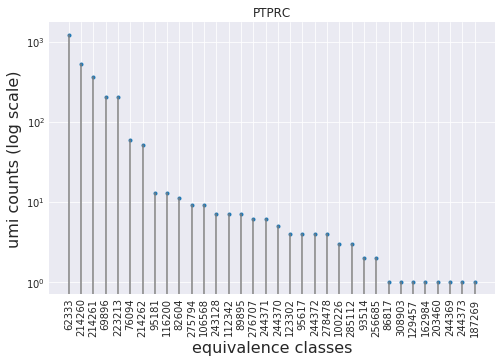

In [13]:
gene='PTPRC'

# compute total counts in each equivalence class associated with the gene
ec_counts=np.array(np.sum(X[:,gene_names_to_ECs[gene]],axis=0))[0] 
# extract the equivalence class ids for non-zero TCCs
gene_ecs0=np.array(gene_names_to_ECs[gene])[np.where(ec_counts>0)[0]]
# filter out zero TCCs
ec_counts=ec_counts[np.where(ec_counts>0)[0]]

# sort TCCs (decreasing total counts)
arg_srt_ec_counts=np.argsort(ec_counts)[::-1] 
ec_counts_srt=ec_counts[arg_srt_ec_counts]

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),ec_counts_srt,'gray',markerfmt='.')
plt.xticks(range(len(ec_counts)),gene_ecs0[arg_srt_ec_counts],rotation='vertical')
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts (log scale)",fontsize=16)
plt.yscale('log')
plt.title(gene)

#### Apply simple filtering threshold
    Filter out equivalence classes with less than 0.003 counts per cell  

threshold= 27.0 (0.0030 counts per cell)


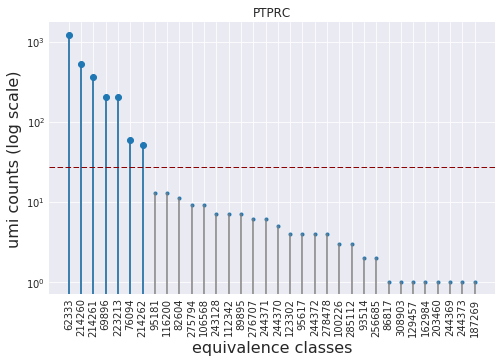

In [14]:
threshold=0.003*X.shape[0]
print('threshold=',threshold,'('+'{0:.4f}'.format(threshold/X.shape[0])+' counts per cell)')
# get the equivalence class ids with TCCs above the threshold
gene_ecs=gene_ecs0[np.where(ec_counts>threshold)[0]]

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),ec_counts_srt,'gray',markerfmt='.')

upto=len(gene_ecs)
plt.stem(range(upto),ec_counts_srt[:upto])
plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)

plt.xticks(range(len(ec_counts)),gene_ecs0[arg_srt_ec_counts],rotation='vertical')
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts (log scale)",fontsize=16)
plt.yscale('log')
plt.title(gene)
plt.show()

In [15]:
tot_counts = np.sum(ec_counts) #total counts in equivalence classes
fract=np.sum(ec_counts_srt[:upto])/tot_counts # fraction of counts in ecs above threshold
print('fraction of counts in ecs above threshold:'+' {0:.1f}'.format(100*fract)+'%' )

fraction of counts in ecs above threshold: 95.4%


#### Lets do this again for another gene (IFITM3)

threshold= 27.0 (0.0030 counts per cell)


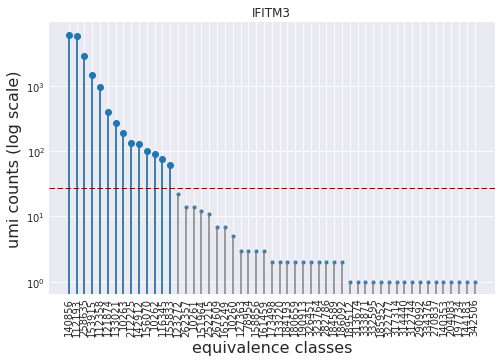

fraction of counts in ecs above threshold: 99.2%


In [16]:
gene='IFITM3'

# compute total counts in each equivalence class associated with the gene
ec_counts=np.array(np.sum(X[:,gene_names_to_ECs[gene]],axis=0))[0] 
# extract the equivalence class ids for non-zero TCCs
gene_ecs0=np.array(gene_names_to_ECs[gene])[np.where(ec_counts>0)[0]]
# filter out zero TCCs
ec_counts=ec_counts[np.where(ec_counts>0)[0]]

# sort TCCs (decreasing total counts)
arg_srt_ec_counts=np.argsort(ec_counts)[::-1] 
ec_counts_srt=ec_counts[arg_srt_ec_counts]

threshold=0.003*X.shape[0]
print('threshold=',threshold,'('+'{0:.4f}'.format(threshold/X.shape[0])+' counts per cell)')

# get the equivalence class ids with TCCs above the threshold
gene_ecs=gene_ecs0[np.where(ec_counts>threshold)[0]]

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),ec_counts_srt,'gray',markerfmt='.')

upto=len(gene_ecs)
plt.stem(range(upto),ec_counts_srt[:upto])
plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)

plt.xticks(range(len(ec_counts)),gene_ecs0[arg_srt_ec_counts],rotation='vertical')
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts (log scale)",fontsize=16)
plt.yscale('log')
plt.title(gene)
plt.show()
tot_counts = np.sum(ec_counts) #total counts in equivalence classes
fract=np.sum(ec_counts_srt[:upto])/tot_counts # fraction of counts in ecs above threshold
print('fraction of counts in ecs above threshold:'+' {0:.1f}'.format(100*fract)+'%' )

In [17]:
print("We kept the following ",len(gene_ecs),' ECs:')
print(gene_ecs)

We kept the following  14  ECs:
[ 10262  10263 112193 112358 116345 121874 133021 140856 142912 153915
 155833 156070 212225 258635]


    Lets check whether the eq. classes we kept are intergenic or not

In [18]:
print('tcc_id', '\tmapped genes' )
for i in gene_ecs:
    print(i, '\t',EC_to_gene_names[i])

tcc_id 	mapped genes
10262 	 ['IFITM3']
10263 	 ['IFITM3']
112193 	 ['IFITM1', 'IFITM3']
112358 	 ['IFITM1', 'IFITM2', 'IFITM3']
116345 	 ['IFITM1', 'IFITM3']
121874 	 ['IFITM3']
133021 	 ['IFITM3']
140856 	 ['IFITM1', 'IFITM2', 'IFITM3']
142912 	 ['AC006970.1', 'AC116049.1', 'IFITM1', 'IFITM2', 'IFITM3', 'IFITM9P']
153915 	 ['IFITM1', 'IFITM2', 'IFITM3']
155833 	 ['AC006970.1', 'IFITM1', 'IFITM2', 'IFITM3', 'IFITM9P']
156070 	 ['AC006970.1', 'IFITM1', 'IFITM2', 'IFITM3']
212225 	 ['IFITM3']
258635 	 ['IFITM1', 'IFITM2', 'IFITM3']


     Unfortunately, in this case many highly expressed equivalence classes (TCCs) map to more than one gene. 
     Interestingly, however, all the genes seem to belong to the same gene-family. One idea is to identify 
     these gene families as connected components of the bipartite EC to gene graph and test for DE between 
     gene families instead of single genes; this way we can still utilize "meaningful" intergenic reads. 


For now we can just follow the conventional approach and filter out intergenic reads.

### Filtering out intergenic reads

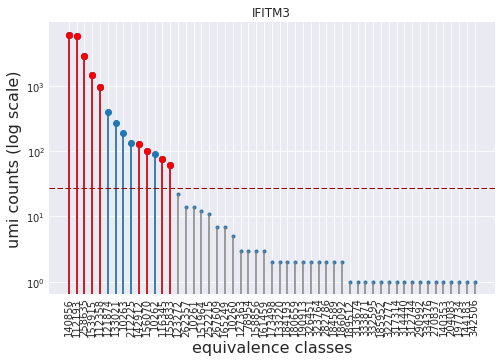

fraction of counts in ecs above threshold: 99.2%


In [19]:
# compute the ec. class size (defined as the number of genes an eq class maps to)
sz=np.array( [len(EC_to_gene_names[i]) for i in gene_ecs0[arg_srt_ec_counts]])

# find the unique and intergenic ECs
idx=np.where(sz==1)[0]
idx_m=np.where(sz>1)[0]

plt.figure(figsize=(8,5))

plt.stem(range(len(ec_counts)),ec_counts_srt,'gray',markerfmt='.')
upto=len(gene_ecs)
plt.stem(range(upto),ec_counts_srt[:upto])
plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)

# mark intergenic eq. classes that are above the threshold with red color
plt.stem(idx_m[idx_m<upto],ec_counts_srt[idx_m[idx_m<upto]],'-or')


plt.xticks(range(len(ec_counts)),gene_ecs0[arg_srt_ec_counts],rotation='vertical')
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts (log scale)",fontsize=16)
plt.yscale('log')
plt.title(gene)
plt.show()
tot_counts = np.sum(ec_counts) #total counts in equivalence classes
fract=np.sum(ec_counts_srt[:upto])/tot_counts # fraction of counts in ecs above threshold
print('fraction of counts in ecs above threshold:'+' {0:.1f}'.format(100*fract)+'%' )

    NOTE: intergenic eq. classes that are above the threshold are marked with red color.
    We keep the ecs that are above the threshold and are *not* intergenic (blue)

In [20]:
#get the final list of ecs that are above the threshold and are *not* intergenic
filtered_ecs=list(gene_ecs0[arg_srt_ec_counts[idx[idx<upto]]])

# the fraction of reads in filtered ecs (counts in filtered ecs divided by the total counts of non-intergenic ecs)
frac=np.sum(ec_counts_srt[idx[idx<upto]])/np.sum(ec_counts_srt[idx])

# total counts in filtered ecs
avg_cnt=np.sum(ec_counts_srt[idx[idx<upto]])/X.shape[0]


print('fraction of counts in filtered unique ecs:'+' {0:.1f}'.format(100*frac)+'%')
print('average gene counts after filtering:'+' {0:.3f}'.format(avg_cnt)+' per cell')

fraction of counts in filtered unique ecs: 98.3%
average gene counts after filtering: 0.120 per cell


### group everything into a single function:

In [21]:
def plot_gene_filt(gene,threshold=20,_size=(8,5)):    
    ##########################################################################################
    try:
        ec_counts=np.array(np.sum(X[:,gene_names_to_ECs[gene]],axis=0))[0]
        gene_ecs0=np.array(gene_names_to_ECs[gene])[np.where(ec_counts>0)[0]]
        ec_counts=ec_counts[np.where(ec_counts>0)[0]]

        if len(ec_counts)==0:
            filtered_ecs=[]
            print(gene)
            print('filtered_ecs =',filtered_ecs)
            print('--------------------------------------------------------------------------------------------------------------')
        else:

            threshold=threshold

            gene_ecs=gene_ecs0[np.where(ec_counts>threshold)[0]]
            upto=len(gene_ecs)

            arg_srt_ec_counts=np.argsort(ec_counts)[::-1]
            ec_counts_srt=ec_counts[arg_srt_ec_counts]
            tot_counts = np.sum(ec_counts)

            plt.figure(figsize=_size)
            plt.stem(range(len(ec_counts)),ec_counts_srt,'gray',markerfmt='.')

            plt.xticks(range(len(ec_counts)),gene_ecs0[arg_srt_ec_counts],rotation='vertical')
            # plt.xlim([0,len(b)+0.9])

            fract=0
            if upto>0: 
                plt.stem(range(upto),ec_counts_srt[:upto])
                fract=np.sum(ec_counts_srt[:upto])/tot_counts

            sz=np.array( [len(EC_to_gene_names[i]) for i in gene_ecs0[arg_srt_ec_counts]])
            idx=np.where(sz==1)[0]
            idx_m=np.where(sz>1)[0]

            # plt.stem(idx[idx<=upto],threshold*np.ones_like(np.sort(ec_counts)[::-1][idx[idx<=upto]]),'r','.')

            filtered_ecs=list(gene_ecs0[arg_srt_ec_counts[idx[idx<upto]]])
            frac=0
            avg_cnt=0
            if len(filtered_ecs)>0: 
                if len(idx_m[idx_m<upto])>0: plt.stem(idx_m[idx_m<upto],ec_counts_srt[idx_m[idx_m<upto]],'-or')
                frac=np.sum(ec_counts_srt[idx[idx<upto]])/np.sum(ec_counts_srt[idx])
                avg_cnt=np.sum(ec_counts_srt[idx[idx<upto]])/X.shape[0]
            plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
            plt.xlabel("equivalence classes",fontsize=16)
            plt.ylabel("umi counts (log scale)",fontsize=16)
            plt.yscale('log')
            plt.title(gene)

            print('threshold=',threshold,'('+'{0:.4f}'.format(threshold/X.shape[0])+' counts per cell)')
            plt.show()
            print('filtered_ecs =',filtered_ecs)
            print('\nfraction of counts in ecs above threshold:'+' {0:.1f}'.format(100*fract)+'%' )
            print('fraction of counts in filtered unique ecs:'+' {0:.1f}'.format(100*frac)+'%')
            print('average gene counts after filtering:'+' {0:.3f}'.format(avg_cnt)+' per cell')
            print('--------------------------------------------------------------------------------------------------------------')
    except KeyError:
        print(gene,' not found')

threshold= 27.0 (0.0030 counts per cell)


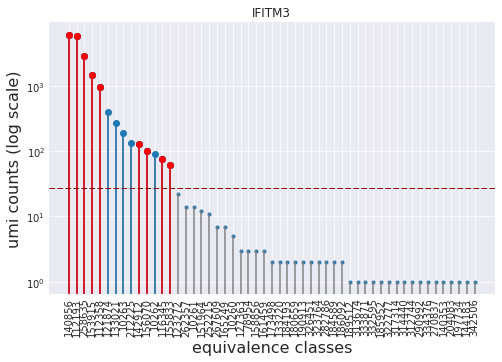

filtered_ecs = [121874, 133021, 10263, 212225, 10262]

fraction of counts in ecs above threshold: 99.2%
fraction of counts in filtered unique ecs: 98.3%
average gene counts after filtering: 0.120 per cell
--------------------------------------------------------------------------------------------------------------


In [22]:
plot_gene_filt('IFITM3',threshold=0.003*X.shape[0])

# Gene examples

threshold= 27.0 (0.0030 counts per cell)


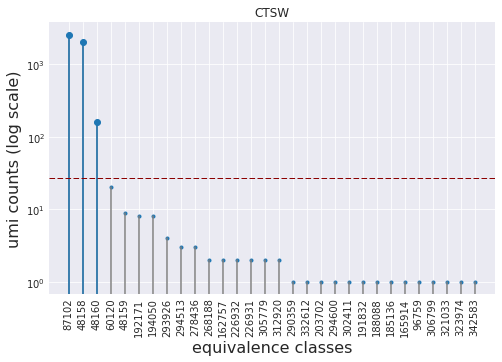

filtered_ecs = [87102, 48158, 48160]

fraction of counts in ecs above threshold: 98.3%
fraction of counts in filtered unique ecs: 99.3%
average gene counts after filtering: 0.526 per cell
--------------------------------------------------------------------------------------------------------------


In [23]:
plot_gene_filt('CTSW',threshold=0.003*X.shape[0])

threshold= 27.0 (0.0030 counts per cell)


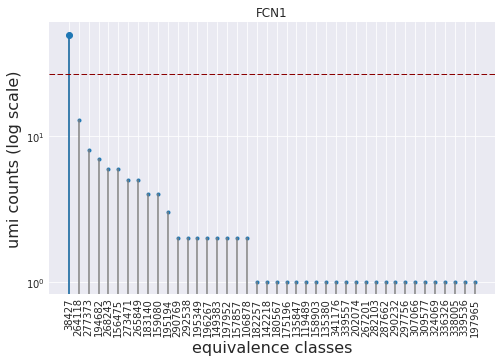

filtered_ecs = [38427]

fraction of counts in ecs above threshold: 33.3%
fraction of counts in filtered unique ecs: 100.0%
average gene counts after filtering: 0.006 per cell
--------------------------------------------------------------------------------------------------------------


In [24]:
plot_gene_filt('FCN1',threshold=0.003*X.shape[0])

threshold= 27.0 (0.0030 counts per cell)


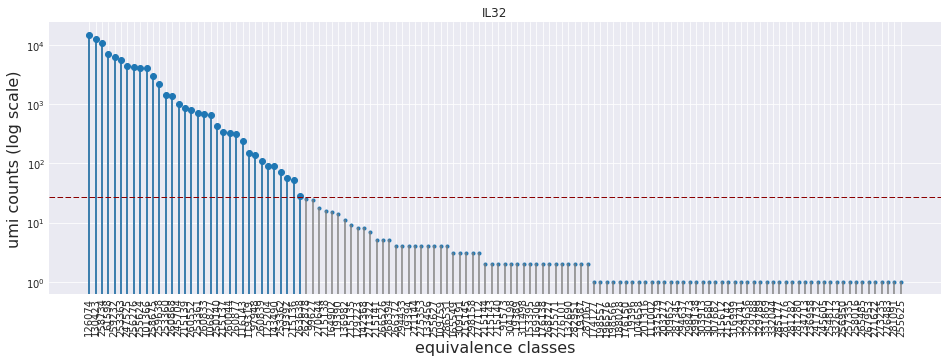

filtered_ecs = [126074, 130423, 258734, 61598, 259232, 253363, 247525, 256276, 255624, 101366, 258675, 259638, 253360, 260868, 245704, 215139, 260552, 253361, 260833, 106827, 250140, 215137, 260044, 260877, 116143, 119319, 97948, 260839, 125204, 143490, 253362, 19392, 215136, 263638]

fraction of counts in ecs above threshold: 99.7%
fraction of counts in filtered unique ecs: 99.7%
average gene counts after filtering: 10.069 per cell
--------------------------------------------------------------------------------------------------------------


In [25]:
plot_gene_filt('IL32',threshold=0.003*X.shape[0],_size=(16,5))

threshold= 27.0 (0.0030 counts per cell)


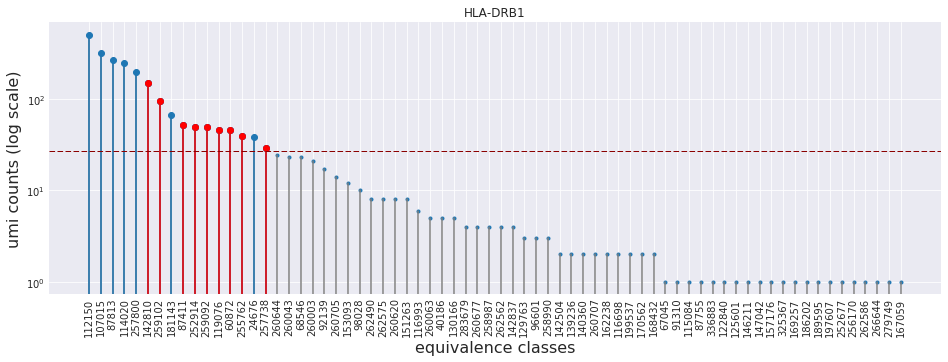

filtered_ecs = [112150, 107015, 87813, 114020, 257800, 181143, 24676]

fraction of counts in ecs above threshold: 89.2%
fraction of counts in filtered unique ecs: 95.7%
average gene counts after filtering: 0.181 per cell
--------------------------------------------------------------------------------------------------------------


In [26]:
plot_gene_filt('HLA-DRB1',threshold=0.003*X.shape[0],_size=(16,5))

threshold= 27.0 (0.0030 counts per cell)


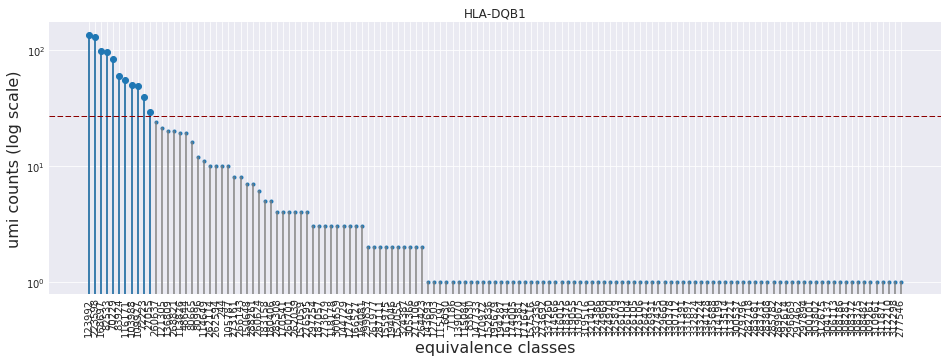

filtered_ecs = [123992, 223598, 168697, 82533, 70229, 83924, 116171, 103988, 109927, 72223, 27055]

fraction of counts in ecs above threshold: 67.4%
fraction of counts in filtered unique ecs: 80.0%
average gene counts after filtering: 0.091 per cell
--------------------------------------------------------------------------------------------------------------


In [27]:
plot_gene_filt('HLA-DQB1',threshold=0.003*X.shape[0],_size=(16,5))

threshold= 18.0 (0.0020 counts per cell)


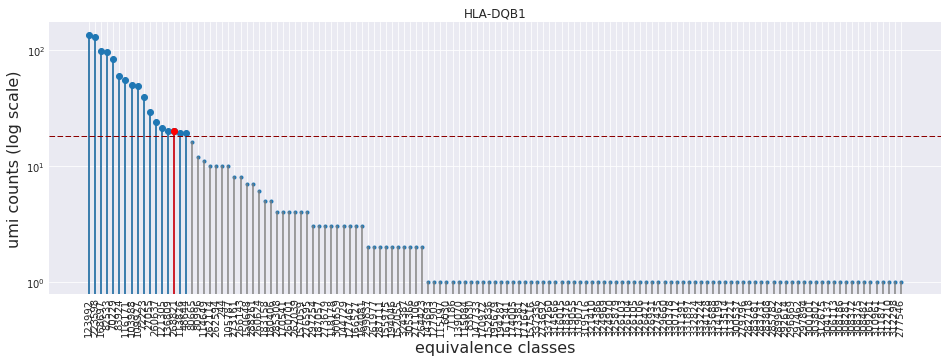

filtered_ecs = [123992, 223598, 168697, 82533, 70229, 83924, 116171, 103988, 109927, 72223, 27055, 260637, 121305, 136809, 113826, 48644]

fraction of counts in ecs above threshold: 77.4%
fraction of counts in filtered unique ecs: 90.1%
average gene counts after filtering: 0.103 per cell
--------------------------------------------------------------------------------------------------------------


In [28]:
# try an even smaller threshold to 0.002 (some genes can be very spread out in TCCs)
plot_gene_filt('HLA-DQB1',threshold=0.002*X.shape[0],_size=(16,5))

threshold= 27.0 (0.0030 counts per cell)


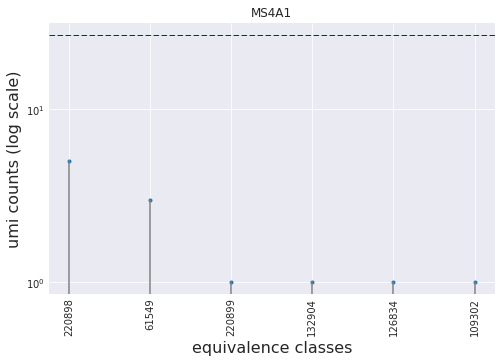

filtered_ecs = []

fraction of counts in ecs above threshold: 0.0%
fraction of counts in filtered unique ecs: 0.0%
average gene counts after filtering: 0.000 per cell
--------------------------------------------------------------------------------------------------------------


In [29]:
#This is a B-cell marker; not expressed in this dataset (T-cells)
plot_gene_filt('MS4A1',threshold=0.003*X.shape[0])

threshold= 27.0 (0.0030 counts per cell)


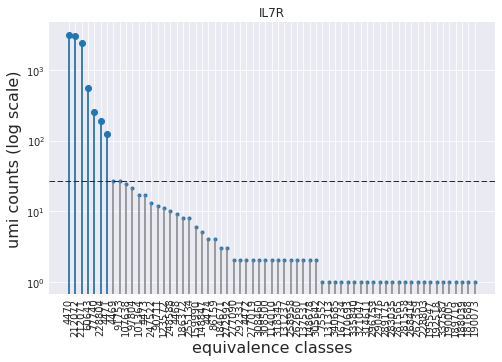

filtered_ecs = [4470, 212072, 212071, 60643, 77740, 228804, 4471]

fraction of counts in ecs above threshold: 97.2%
fraction of counts in filtered unique ecs: 98.2%
average gene counts after filtering: 1.092 per cell
--------------------------------------------------------------------------------------------------------------


In [30]:
# CD4 T cell marker
plot_gene_filt('IL7R',threshold=0.003*X.shape[0])

threshold= 27.0 (0.0030 counts per cell)


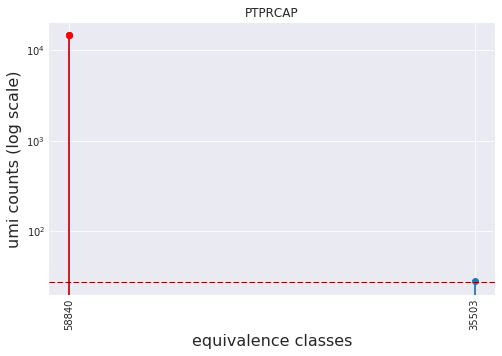

filtered_ecs = [35503]

fraction of counts in ecs above threshold: 100.0%
fraction of counts in filtered unique ecs: 100.0%
average gene counts after filtering: 0.003 per cell
--------------------------------------------------------------------------------------------------------------


In [31]:
plot_gene_filt('PTPRCAP',threshold=0.003*X.shape[0])

     The above gene is associated with a very highly expressed integenic eq.class (id 58840)


In [32]:
EC_to_gene_names[58840]

['CORO1B', 'PTPRCAP']

    this equivalence class is most likely associated with the highly expressed gene CORO1B 
    (although no way to say for sure without a read genearating model)

threshold= 27.0 (0.0030 counts per cell)


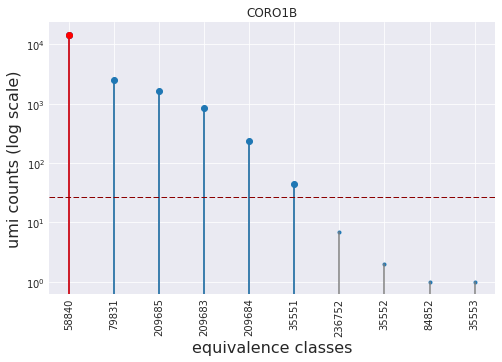

filtered_ecs = [79831, 209685, 209683, 209684, 35551]

fraction of counts in ecs above threshold: 99.9%
fraction of counts in filtered unique ecs: 99.8%
average gene counts after filtering: 0.588 per cell
--------------------------------------------------------------------------------------------------------------


In [33]:
plot_gene_filt('CORO1B',threshold=0.003*X.shape[0])

# Differential expression

Ok lets focus on PTPRC again

threshold= 27.0 (0.0030 counts per cell)


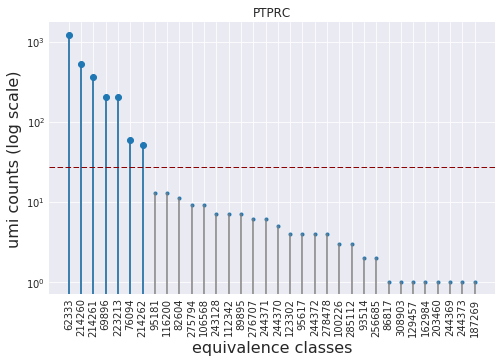

filtered_ecs = [62333, 214260, 214261, 69896, 223213, 76094, 214262]

fraction of counts in ecs above threshold: 95.4%
fraction of counts in filtered unique ecs: 95.4%
average gene counts after filtering: 0.290 per cell
--------------------------------------------------------------------------------------------------------------


In [34]:
gene='PTPRC'
plot_gene_filt(gene,threshold=0.003*X.shape[0])

##### Logistic regression

We will use the filtered_ecs [62333, 214260, 214261, 69896, 223213, 76094, 214262] associated with PTPRC to detect DE based on a logistic regression model. The key idea here is to test whether a linear combination of the above 7 TCCs is differentially expressed between, say, memory and naive T-cells. Intuitively, logistic regression is used to identify this separating linear combination. We can think of cells as points in 7-dimensional space and use the resulting logistic regression coefficients to identify the best separating hyperplane between memory and naive cells. We can obtain a single gene level p-value for PTPRC by evaluating how well logistic regression is able to sepaprate the cells in 7-dimensions (with a likelihood ratio test). 
    
    Note that this approach is fundamentally different than testing each 1-dimensional TCC independently.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import math

In [36]:
## READ CELL LABELS
labels=np.array(pd.read_csv('./cell.labels',header=None)).reshape(1,-1)[0]

#### logistic regression function

In [37]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression(C=1000)
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = stats.chi2.sf(2*llr,k) #survival function defined as 1-cdf
    
    return [logr,llr_pval]

In [38]:
X_naive=X[np.squeeze(labels=='Naive'),:]
X_mem=X[np.squeeze(labels=='Mem'),:]
X_cyto=X[np.squeeze(labels=='Cyto'),:]

In [39]:
print("naive cells: ",X_naive.shape[0])
print("mem cells: ",X_mem.shape[0])
print("cyto cells: ",X_cyto.shape[0])

naive cells:  3000
mem cells:  3000
cyto cells:  3000


In [40]:
sns.set_style("white")

### Naive vs Memory cells 

pval= 9.01702446217608e-06


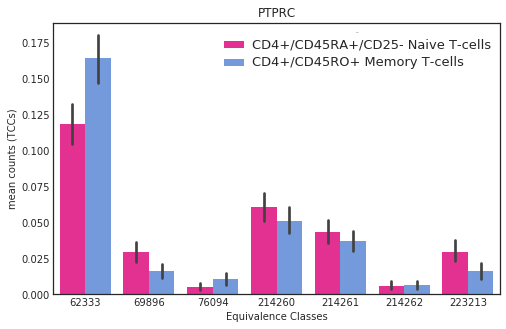

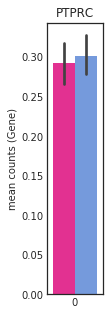

In [41]:
ecidx = [62333, 214260, 214261, 69896, 223213, 76094, 214262]

X1=X_naive
X2=X_mem
A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])

######################################## plot #############################################
X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=ecidx)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=ecidx)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()

Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

### Naive vs Cyto 

pval= 0.7203043494006982


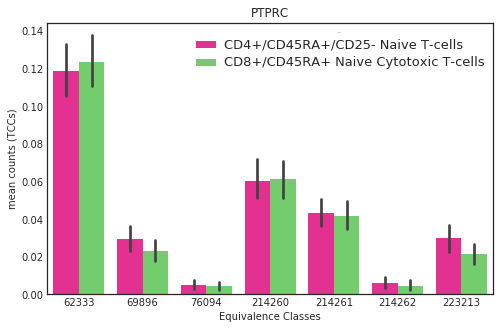

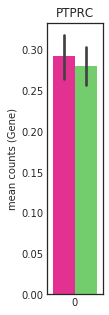

In [42]:
ecidx = [62333, 214260, 214261, 69896, 223213, 76094, 214262]

X1=X_naive
X2=X_cyto
A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])

######################################## plot #############################################
X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=ecidx)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=ecidx)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()

Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

### Cyto vs Memory 

pval= 0.0002714576285260956


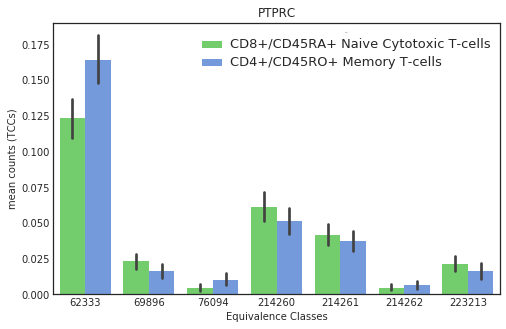

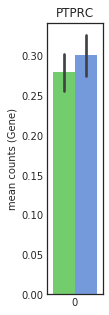

In [43]:
ecidx = [62333, 214260, 214261, 69896, 223213, 76094, 214262]

X1=X_cyto
X2=X_mem
A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])

######################################## plot #############################################
X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=ecidx)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(X2_ecidx,columns=ecidx)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()

Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

In [44]:
# temp plot function
def plot_mem_naive_DE(gene):
    ecidx = gene_names_to_filtECs[gene]

    X1=X_naive
    X2=X_mem
    A=logr_ecidx(ecidx,X1,X2)
    print('pval=',A[1])

    ######################################## plot #############################################
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()

    P1=pd.DataFrame(X1_ecidx,columns=ecidx)
    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
    P2=pd.DataFrame(X2_ecidx,columns=ecidx)
    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
    P=P1.append(P2)
    df = pd.melt(P,  id_vars='cluster')

    plt.figure(figsize=(8,5))
    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"],data=df)
    ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
    plt.title(gene)
    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
    plt.setp(ax.get_legend().get_title(), fontsize='0')
    plt.show()

    Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
    Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

    P1=pd.DataFrame(Gexp1.T,)
    P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
    P2=pd.DataFrame(Gexp2.T)
    P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
    P=P1.append(P2)
    df = pd.melt(P,  id_vars='cluster')

    plt.figure(figsize=(1,5))
    ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
    ax.set(xlabel='', ylabel='mean counts (Gene)')
    ax.legend_.remove()
    plt.title(gene)
    plt.show()

# DE for all genes

    Create a map from gene_names to filtered ec indices 

In [45]:
all_ec_counts=np.array(np.sum(X,axis=0))[0]

In [46]:
def get_gene_filt(gene,threshold=20):    
    ##########################################################################################
    try:
        gene_ecs0=np.array(gene_names_to_ECs[gene])
        ec_counts=all_ec_counts[gene_ecs0]
        
        threshold=threshold
        gene_ecs=gene_ecs0[np.where(ec_counts>threshold)[0]]
        
        sz=np.array( [len(EC_to_gene_names[i]) for i in gene_ecs])
        idx=np.where(sz==1)[0]
        return list(gene_ecs[idx])
            
    except KeyError:
        return []

In [47]:
#
# gene_names_to_filtECs map
#
threshold=0.003*X.shape[0]
gene_names_to_filtECs={}
for gene in gene_names_to_ECs.keys():
    gene_names_to_filtECs[gene] = get_gene_filt(gene,threshold=threshold)

In [48]:
# sanity check
gene_names_to_filtECs['PTPRC']

[62333, 69896, 76094, 214260, 214261, 214262, 223213]

In [49]:
def get_pval(gene,X1,X2):
    ecidx = gene_names_to_filtECs[gene]
    return -1 if len(ecidx)==0 else logr_ecidx(ecidx,X1,X2)[1]

In [50]:
#sanity check
get_pval('PTPRC',X_mem,X_naive)

9.01702446217608e-06

In [51]:
# returns -1 if all ecs of a gene are filtered out:
get_pval('MS4A1',X_mem,X_naive)

-1

#### examples

In [52]:
genes=['PTPRC','IL7R','CTSW','MS4A1','HLA-DRB1','PTPRCAP','IFITM3','S100A4', 'CCR7']
for gene in genes:
    print(gene,end='')
    print(''.join([' ' for i in range(20-len(gene))]),end='')
    print('\t',get_pval(gene,X_mem,X_naive))

PTPRC               	 9.01702446217608e-06
IL7R                	 1.3151726417822684e-59
CTSW                	 0.0002703294628608776
MS4A1               	 -1
HLA-DRB1            	 5.03241865633961e-59
PTPRCAP             	 0.34304248959539774
IFITM3              	 0.00293366522384228
S100A4              	 0.0
CCR7                	 4.0021963306142976e-120


    Some genes are clearly differentially expressed resulting in extremely small p-values

pval= 0.0


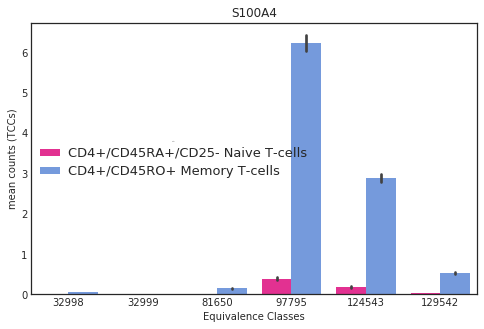

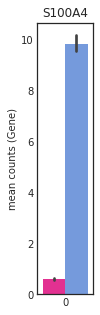

In [53]:
# for example S100A4 is a memory T-cell marker

plot_mem_naive_DE('S100A4')

pval= 4.0021963306179504e-120


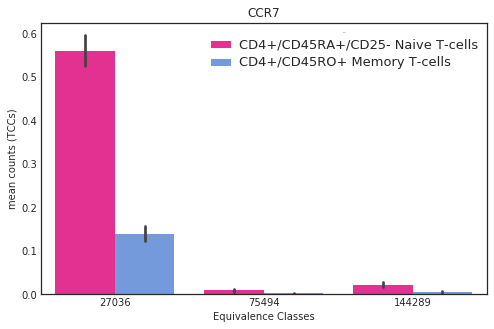

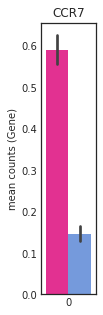

In [54]:
# and CCR7 is a marker for naive cells

plot_mem_naive_DE('CCR7')

    The above genes are differentially expressed along the "gene" direction. It would be interesting to find
    genes that have very similar gene counts but are differentially expressed at the TCC/isoform level

# DE on genes with similar gene counts

In [55]:
def get_gene_counts_pval(gene,X1,X2):
    ecidx = gene_names_to_filtECs[gene]
    if len(ecidx)==0 : return -1  ################### return -1 if gene ecs did not pass the filtering
    else:
        N1=X1.shape[0]
        N2=X2.shape[0]
        logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
        logr = LogisticRegression(C=1000)
        p_of_1=N1/float(N1+N2)
        llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
        
        k=1  # one-dimensional test

        X1_ecidx=np.sum(X1[:,ecidx],axis=1)
        X2_ecidx=np.sum(X2[:,ecidx],axis=1)
        c=np.concatenate([X1_ecidx,X2_ecidx])
        #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
        logr.fit(c,logr_labels)
        pred=np.array(logr.predict_proba(c)[:,1])
        gene_score=log_loss(logr_labels,pred)
        llf=-gene_score*(N1+N2)
        llr=llf-llnull
        llr_pval = stats.chi2.sf(2*llr,k) #survival function defined as 1-cdf

    return llr_pval

In [56]:
# test on PTPRC
get_gene_counts_pval('PTPRC',X_mem,X_naive)

0.6488440769236745

#### find interesting genes

In [57]:
def get_mean_gene_counts(gene, X1,X2):
    ecidx=gene_names_to_filtECs[gene]
    return 0.5*(np.mean( X1[:,ecidx].sum(axis=1) ) + np.mean( X2[:,ecidx].sum(axis=1) ))

Select genes that:
1. have average gene counts more than **0.1**
2. the gene counts p-value is larger than **0.5** (i.e., they look very similar along the gene direction)
3. the gene-level p-value after logistic regression on TCCs is smaller than **0.0005** (detect isoform level DE)

In [58]:
%%time
list_of_genes=[]
genecount_pvals=[]
logr_pvals=[]
for gene in gene_names_to_ECs.keys():
    if get_mean_gene_counts(gene,X_mem,X_naive)>0.1: # filter genes with small gene counts
        g_pval=get_gene_counts_pval(gene,X_mem,X_naive)
        if g_pval>0.5:
            pval=get_pval(gene,X_mem,X_naive)
            if pval<0.0005:
                print(gene+' ('+'{0:.2f}'.format(g_pval)+')',end='')
                print(''.join([' ' for i in range(20-len(gene))]),end='')
                print('\t','{0:.2e}'.format(pval))
                
                list_of_genes+=[gene]
                genecount_pvals+=[g_pval]
                logr_pvals+=[pval]
 

ATP5A1 (0.85)              	 2.38e-07
XBP1 (0.78)                	 6.01e-11
AES (0.70)                 	 3.30e-08
ZNF207 (0.92)              	 3.16e-04
PTMA (0.81)                	 4.20e-27
WDR74 (0.92)               	 5.57e-07
FAM133B (0.83)             	 4.57e-04
EIF2D (0.58)               	 1.47e-05
FYB1 (0.66)                	 1.27e-05
DDX17 (0.99)               	 2.00e-11
RPS3A (0.80)               	 3.01e-15
NCOR1 (0.78)               	 2.51e-04
TAX1BP1 (0.71)             	 1.41e-07
CALM3 (0.90)               	 3.61e-18
PTPRC (0.65)               	 9.02e-06
TUBB (0.92)                	 1.68e-04
CPU times: user 28min 38s, sys: 19min 9s, total: 47min 47s
Wall time: 27min 49s


ATP5A1
pval= 2.3801739627565222e-07


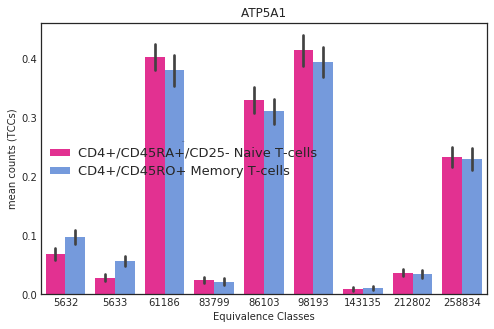

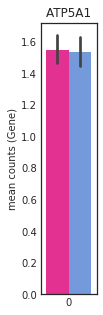

-------------------------------------------------------------------------------------------
XBP1
pval= 6.005280145821959e-11


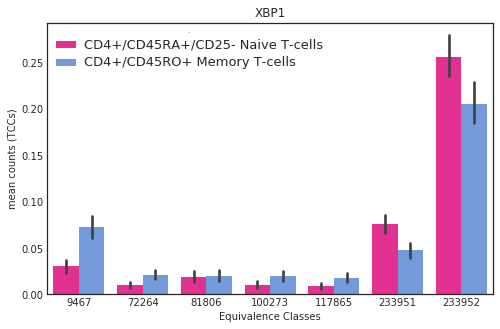

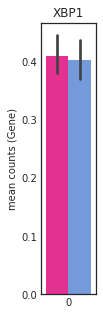

-------------------------------------------------------------------------------------------
AES
pval= 3.300849492087421e-08


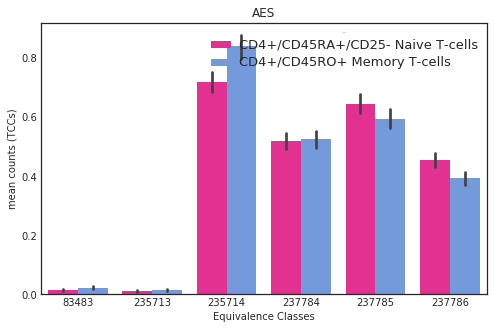

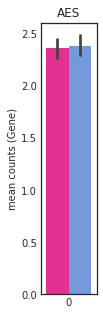

-------------------------------------------------------------------------------------------
ZNF207
pval= 0.0003156590763150549


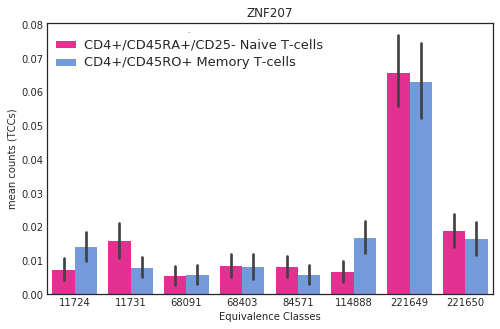

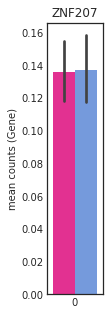

-------------------------------------------------------------------------------------------
PTMA
pval= 4.195375167231177e-27


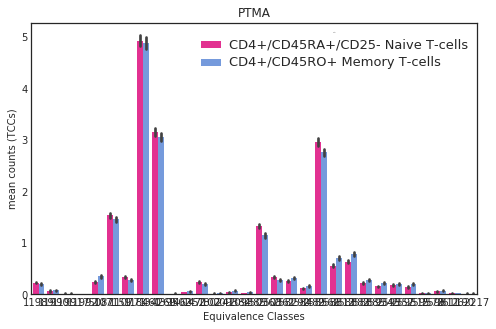

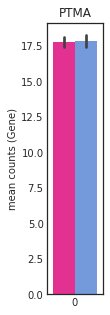

-------------------------------------------------------------------------------------------
WDR74
pval= 5.574286004480433e-07


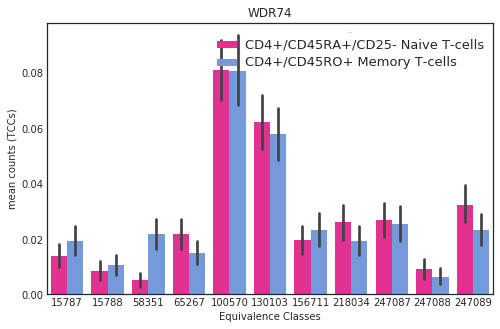

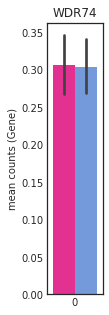

-------------------------------------------------------------------------------------------
FAM133B
pval= 0.000457170664797436


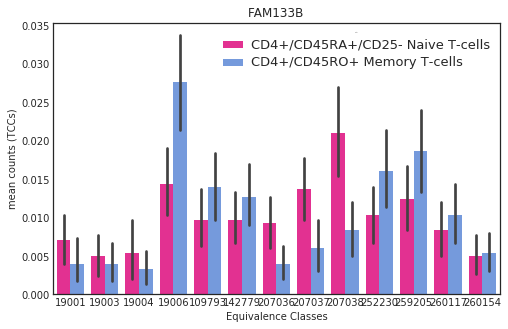

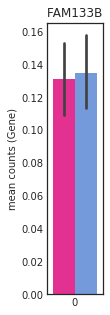

-------------------------------------------------------------------------------------------
EIF2D
pval= 1.4734222933431487e-05


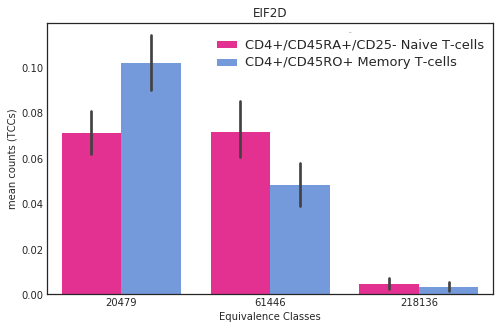

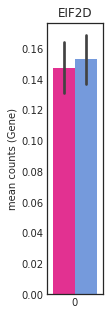

-------------------------------------------------------------------------------------------
FYB1
pval= 1.2690837533536665e-05


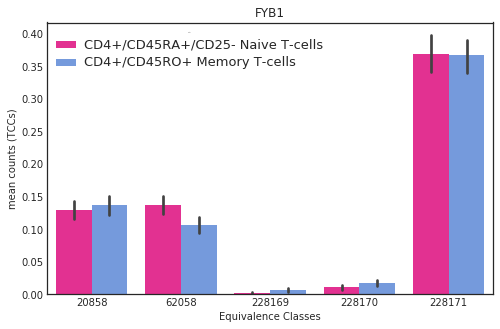

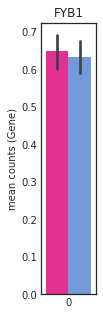

-------------------------------------------------------------------------------------------
DDX17
pval= 2.0042060886982746e-11


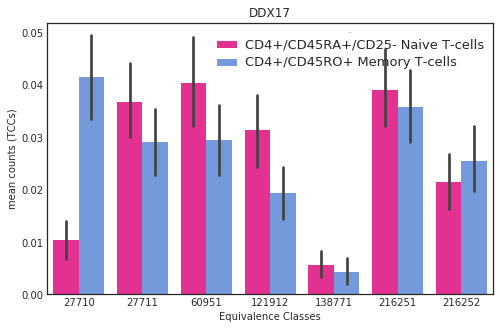

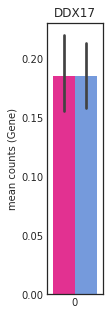

-------------------------------------------------------------------------------------------
RPS3A
pval= 3.0137813731119277e-15


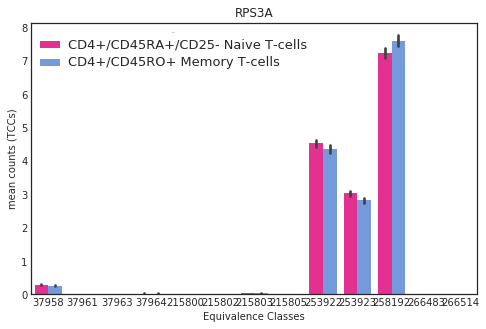

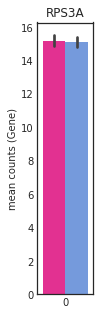

-------------------------------------------------------------------------------------------
NCOR1
pval= 0.00025132503260507527


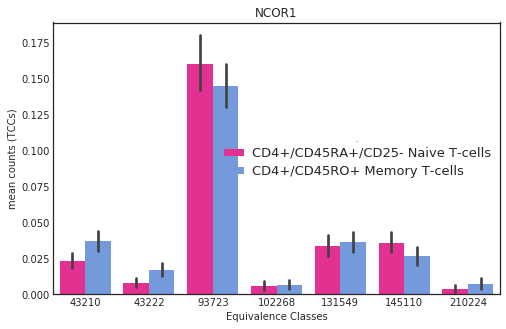

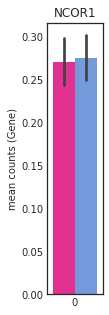

-------------------------------------------------------------------------------------------
TAX1BP1
pval= 1.4055421269590867e-07


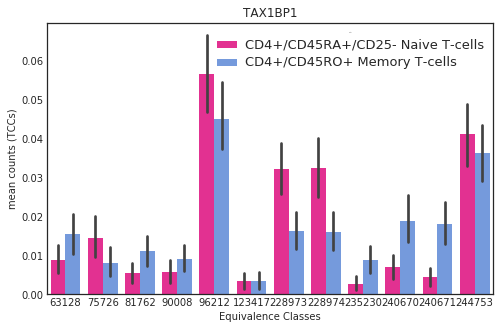

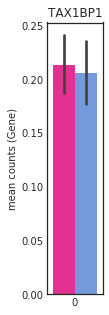

-------------------------------------------------------------------------------------------
CALM3
pval= 3.611434295566078e-18


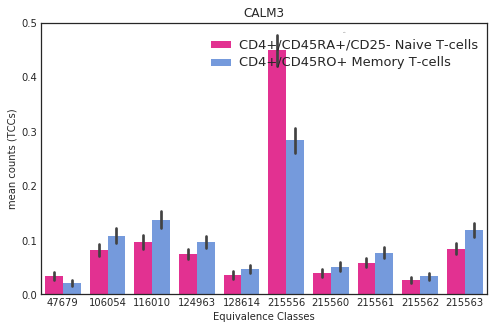

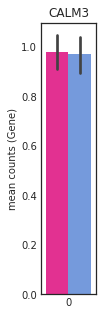

-------------------------------------------------------------------------------------------
PTPRC
pval= 9.01702446217608e-06


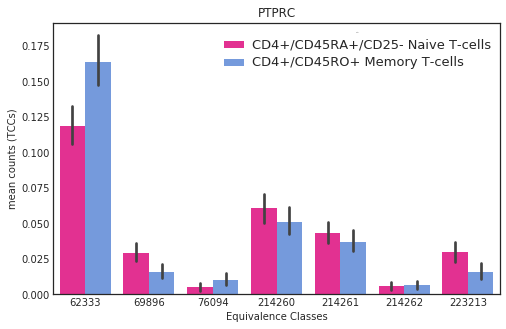

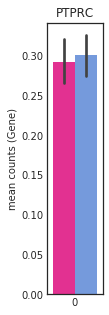

-------------------------------------------------------------------------------------------
TUBB
pval= 0.00016830442415843432


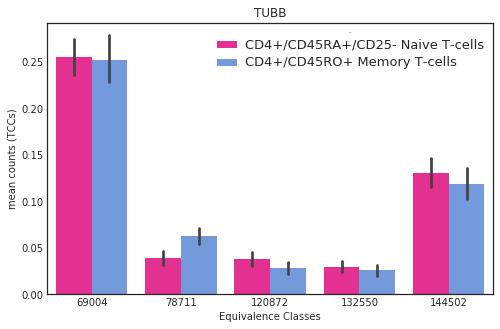

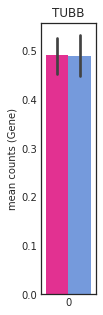

-------------------------------------------------------------------------------------------


In [59]:
for g in list_of_genes:
    print(g)
    plot_mem_naive_DE(g)
    print('-------------------------------------------------------------------------------------------')

# DE for all genes
    Here we focus on the first 1000 mem and naive cells and consider DE across 
    all genes with more than 0.3 average counts

In [60]:
%%time
list_of_all_genes=[]
all_genecount_pvals=[]
all_logr_pvals=[]
for gene in gene_names_to_ECs.keys():
    if get_mean_gene_counts(gene,X_mem[:1000,:],X_naive[:1000,:])>0.3: # filter genes with small gene counts
        g_pval=get_gene_counts_pval(gene,X_mem[:1000,:],X_naive[:1000,:])
        pval=get_pval(gene,X_mem[:1000,:],X_naive[:1000,:])
        list_of_all_genes+=[gene]
        all_genecount_pvals+=[g_pval]
        all_logr_pvals+=[pval]

CPU times: user 23min 58s, sys: 53min 21s, total: 1h 17min 20s
Wall time: 27min 32s


In [61]:
all_logr_pvals=np.array(all_logr_pvals)
list_of_all_genes=np.array(list_of_all_genes)
all_genecount_pvals=np.array(all_genecount_pvals)

In [62]:
srt_idx=np.argsort(all_logr_pvals)

In [63]:
#exclude RP genes from test
non_RP=len(list_of_all_genes)-np.sum([list_of_all_genes[i].startswith('RP') for i in range(len(list_of_all_genes))])
print('genes tested (excluding RP) = ',non_RP)

genes tested (excluding RP) =  802


### Print significant genes

In [64]:
print('gene_name',end='')
print(''.join([' ' for i in range(30-len('gene_name'))]),end='')
print('\t','logr_pval'+'(corrected)')
print('__________________________________________________________________')               
for i in range(len(list_of_all_genes)):
    if not list_of_all_genes[srt_idx[i]].startswith('RP'):
        if all_logr_pvals[srt_idx[i]]<=.01/float(non_RP): # multiple testing correction at FWER=1% 
            print(list_of_all_genes[srt_idx[i]],end='')
            print(''.join([' ' for i in range(30-len(list_of_all_genes[srt_idx[i]]))]),end='')
            print('\t','{0:.2e}'.format(all_logr_pvals[srt_idx[i]])+' ('+'{0:.2e}'.format(all_logr_pvals[srt_idx[i]]*non_RP)+')')

gene_name                     	 logr_pval(corrected)
__________________________________________________________________
S100A4                        	 0.00e+00 (0.00e+00)
CRIP1                         	 1.02e-164 (8.15e-162)
IL32                          	 2.33e-160 (1.87e-157)
CD52                          	 9.85e-157 (7.90e-154)
B2M                           	 2.35e-148 (1.88e-145)
TMSB4X                        	 1.11e-135 (8.93e-133)
SH3BGRL3                      	 1.54e-123 (1.24e-120)
S100A6                        	 4.42e-112 (3.55e-109)
S100A10                       	 2.33e-109 (1.87e-106)
TMSB10                        	 6.98e-104 (5.60e-101)
FAU                           	 6.43e-94 (5.16e-91)
LGALS1                        	 4.25e-93 (3.41e-90)
S100A11                       	 2.95e-83 (2.37e-80)
FGF23                         	 7.29e-82 (5.84e-79)
SERF2                         	 6.57e-75 (5.27e-72)
COX2                          	 5.54e-69 (4.44e-66)
ATP5E                         

EEF2                          	 1.09e-06 (8.74e-04)
MRPL23                        	 1.14e-06 (9.12e-04)
ARPC2                         	 1.18e-06 (9.47e-04)
DNPH1                         	 1.28e-06 (1.03e-03)
NDUFC2                        	 1.35e-06 (1.08e-03)
RARRES3                       	 1.39e-06 (1.11e-03)
NDFIP1                        	 1.60e-06 (1.28e-03)
CALM3                         	 1.71e-06 (1.37e-03)
ZFP36                         	 1.81e-06 (1.45e-03)
DDIT4                         	 1.82e-06 (1.46e-03)
SNRPG                         	 1.85e-06 (1.48e-03)
MRPL51                        	 1.87e-06 (1.50e-03)
NPM1                          	 1.87e-06 (1.50e-03)
SUB1                          	 1.87e-06 (1.50e-03)
UBB                           	 1.91e-06 (1.53e-03)
C1orf162                      	 2.10e-06 (1.69e-03)
CHMP2A                        	 2.82e-06 (2.26e-03)
GSTP1                         	 3.98e-06 (3.19e-03)
FAM96B                        	 4.51e-06 (3.62e-03)
EIF3K       